In [1]:
# Interpolating David's COSMIC data onto magnetic latitude (Interpolating ocfr_lon, nmeas_lon and freq_lon separately)
# Using same bins as WACCM data (96 lat bins)

#Unsure if this is getting the correct result... 
# The magnitude of occ freq (%) doesn't seem to match up (by eye) with the lat-lon plots of occurence freq for COSMIC data from COSMIC_WACCM_Plotting-Daviddata.ipynb

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
from tqdm import tqdm

# COSMIC Lat-**Lon** Data Loading (David Themens)

In [3]:
# # Lat-Lon Seasons Separately
# #======================================

# output_spr_lon_file = 'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_spring.nc'
# output_sum_lon_file = 'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_summer.nc'
# output_aut_lon_file = 'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_autumn.nc'
# output_win_lon_file = 'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_winter.nc'

output_spr_lon_file = 'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_2007-2009_2013_spring.nc'
output_sum_lon_file = 'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_2007-2009_2013_summer.nc'
output_aut_lon_file = 'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_2007-2009_2013_autumn.nc'
output_win_lon_file = 'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_2007-2009_2013_winter.nc'

output_spr_lon = xr.open_dataset(output_spr_lon_file)
lat_spr_lon = output_spr_lon['latitude']
lon_spr_lon = output_spr_lon['longitude']
ocfr_spr_lon = output_spr_lon['ocfr_lon']
freq_lon_spr = output_spr_lon['freq_lon']
nmeas_lon_spr = output_spr_lon['nmeas_lon']
nmeas_lonavg_spr = output_spr_lon['nmeas_lonavg']

output_sum_lon = xr.open_dataset(output_sum_lon_file)
lat_sum_lon = output_sum_lon['latitude']
lon_sum_lon = output_sum_lon['longitude']
ocfr_sum_lon = output_sum_lon['ocfr_lon']
freq_lon_sum = output_sum_lon['freq_lon']
nmeas_lon_sum = output_sum_lon['nmeas_lon']
nmeas_lonavg_sum = output_sum_lon['nmeas_lonavg']

output_aut_lon = xr.open_dataset(output_aut_lon_file)
lat_aut_lon = output_aut_lon['latitude']
lon_aut_lon = output_aut_lon['longitude']
ocfr_aut_lon = output_aut_lon['ocfr_lon']
freq_lon_aut = output_aut_lon['freq_lon']
nmeas_lon_aut = output_aut_lon['nmeas_lon']
nmeas_lonavg_aut = output_aut_lon['nmeas_lonavg']

output_win_lon = xr.open_dataset(output_win_lon_file)
lat_win_lon = output_win_lon['latitude']
lon_win_lon = output_win_lon['longitude']
ocfr_win_lon = output_win_lon['ocfr_lon']
freq_lon_win = output_win_lon['freq_lon']
nmeas_lon_win = output_win_lon['nmeas_lon']
nmeas_lonavg_win = output_win_lon['nmeas_lonavg']

# WACCM Raw Files (ALATM/ALONM)- Data Loading

In [4]:
file1name='Nc_Files/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport.cam.h2.0001-03-*.nc'
ds = xr.open_mfdataset(file1name)
#ds

# COSMIC Interpolation onto magnetic lat (seasons separately)

In [ ]:
########### Interpolate ocfr_lon variable (occurrence freq of Es) to mag lat ##########
#============================================

ALATM = ds['ALATM']     #time,lat,lon
avALATM = np.mean(ALATM, axis=0)   # Average over time dimension -> [lat,lon]

lat_min = -75  # Replace with your minimum latitude
lat_max = 75   # Replace with your maximum latitude

latsl = lat_spr_lon.sel(latitude=slice(lat_min, lat_max))
nlat = len(latsl)
nlats = np.arange(0,nlat)

nlons = np.arange(0,144)
n = np.zeros((nlat, 144 ))

# Define seasons and corresponding datasets
seasons = ['spr', 'sum', 'aut', 'win']
datasets = [output_spr_lon, output_sum_lon, output_aut_lon, output_win_lon]

# Initialize arrays for each season
n_values = {season: np.zeros((nlat, nlons.size)) for season in seasons}
Occ_Fr_maglat = {season: np.zeros(nlat) for season in seasons}

# Loop through seasons
for season, dataset in zip(seasons, datasets):
    # Select the relevant dataset for the current season
    ds_season = dataset['ocfr_lon'].sel(latitude=slice(lat_min, lat_max))
    
    # Loop through latitudes with a progress bar
    for ilat in tqdm(nlats, desc=f'Processing {season} data', unit='latitude'):
        for ilon in nlons:
            fp = ds_season[:, ilon].values
            xp = avALATM.sel(lat=slice(lat_min, lat_max))[:, ilon].values
            x = latsl[ilat]
            n_values[season][ilat, ilon] = np.interp(x, xp, fp)

    # Calculate mean along the longitude axis
    Occ_Fr_maglat[season] = np.mean(n_values[season], axis=1)


In [ ]:
###########     ocfr_lon    ##########
########### Save to nc file ##########
#=====================================

dataset.set_index

# Create an empty xarray Dataset to store variables
result_dataset = xr.Dataset()

# Loop through seasons
for season, values in Occ_Fr_maglat.items():
    
    result_dataarray_occ_freq = xr.DataArray(Occ_Fr_maglat[season], coords={'mlat': latsl.values}, 
                                             dims=['mlat'], 
                                             name=f'{season}_Occ_Fr_maglat', 
                                             attrs={'Data': 'Occ Freq interp onto mag lat, avgd over lon dim (avgd over each constant mag lat)', 'Dims': 'mlat'})
    
    # Add the DataArray to the Dataset
    result_dataset[f'{season}_Occ_Fr_maglat'] = result_dataarray_occ_freq

    # Access the corresponding n_values for the current season
    result_dataarray_n_values = xr.DataArray(n_values[season], coords={'mlat': latsl.values, 'lon': ds['lon'].values}, 
                                             dims=['mlat', 'lon'], 
                                             name=f'{season}_Occ_Fr_maglat-lon', 
                                             attrs={'Data': 'Occ Freq interp onto mag lat', 'Dims': 'mlat & lon'})
    
    # Add the DataArray to the Dataset
    result_dataset[f'{season}_Occ_Fr_maglat-lon'] = result_dataarray_n_values
    
    
    #result_dataset = result_dataset.assign_coords(mlat=result_dataset['lat'])
    #result_dataset = result_dataset.rename_dims({'lat': 'mlat'})
    #result_dataset = result_dataset.set_index(mlat='latsl')

output_directory = "./Nc_Files/s4max/Daviddata/maglat/"
output_file = "Occ_Fr_Daviddata_maglat_seasons_2007-2009_2013.nc"
result_dataset.to_netcdf(f'{output_directory}{output_file}')

In [ ]:
########### Interpolate nmeas_lon variable  to mag lat (total number of measurements with or without Es) ##########
#============================================

ALATM = ds['ALATM']     #time,lat,lon
avALATM = np.mean(ALATM, axis=0)   # Average over time dimension -> [lat,lon]

lat_min = -75  # Replace with your minimum latitude
lat_max = 75   # Replace with your maximum latitude

latsl = lat_spr_lon.sel(latitude=slice(lat_min, lat_max))
nlat = len(latsl)
nlats = np.arange(0,nlat)

nlons = np.arange(0,144)
n = np.zeros((nlat, 144 ))

# Define seasons and corresponding datasets
seasons = ['spr', 'sum', 'aut', 'win']
datasets = [output_spr_lon, output_sum_lon, output_aut_lon, output_win_lon]

# Initialize arrays for each season
n_values = {season: np.zeros((nlat, nlons.size)) for season in seasons}
nmeas_maglat = {season: np.zeros(nlat) for season in seasons}

# Loop through seasons
for season, dataset in zip(seasons, datasets):
    # Select the relevant dataset for the current season
    ds_season = dataset['nmeas_lon'].sel(latitude=slice(lat_min, lat_max))
    
    # Loop through latitudes with a progress bar
    for ilat in tqdm(nlats, desc=f'Processing {season} data', unit='latitude'):
        for ilon in nlons:
            fp = ds_season[:, ilon].values
            xp = avALATM.sel(lat=slice(lat_min, lat_max))[:, ilon].values
            x = latsl[ilat]
            n_values[season][ilat, ilon] = np.interp(x, xp, fp)

    # Calculate mean along the longitude axis
    nmeas_maglat[season] = np.mean(n_values[season], axis=1)


In [ ]:
###########     nmeas_lon   ##########
########### Save to nc file ##########
#=====================================

dataset.set_index

# Create an empty xarray Dataset to store variables
result_dataset = xr.Dataset()

# Loop through seasons
for season, values in nmeas_maglat.items():
    
    result_dataarray_occ_freq = xr.DataArray(nmeas_maglat[season], coords={'mlat': latsl.values}, 
                                             dims=['mlat'], 
                                             name=f'{season}_nmeas_maglat', 
                                             attrs={'Data': 'Nmeas_lon interp onto mag lat, avgd over lon dim (avgd over each constant mag lat)', 'Dims': 'mlat'})
    
    # Add the DataArray to the Dataset
    result_dataset[f'{season}_nmeas_maglat'] = result_dataarray_occ_freq

    
output_directory = "./Nc_Files/s4max/Daviddata/maglat/"
output_file = "nmeas_Daviddata_maglat_seasons_2007-2009_2013.nc"
result_dataset.to_netcdf(f'{output_directory}{output_file}')

In [ ]:
########### Interpolate freq_lon variable to mag lat (total number of Es layers identified) ##########
#============================================

ALATM = ds['ALATM']     #time,lat,lon
avALATM = np.mean(ALATM, axis=0)   # Average over time dimension -> [lat,lon]

lat_min = -75  # Replace with your minimum latitude
lat_max = 75   # Replace with your maximum latitude

latsl = lat_spr_lon.sel(latitude=slice(lat_min, lat_max))
nlat = len(latsl)
nlats = np.arange(0,nlat)

nlons = np.arange(0,144)
n = np.zeros((nlat, 144 ))

# Define seasons and corresponding datasets
seasons = ['spr', 'sum', 'aut', 'win']
datasets = [output_spr_lon, output_sum_lon, output_aut_lon, output_win_lon]

# Initialize arrays for each season
n_values = {season: np.zeros((nlat, nlons.size)) for season in seasons}
freq_maglat = {season: np.zeros(nlat) for season in seasons}

# Loop through seasons
for season, dataset in zip(seasons, datasets):
    # Select the relevant dataset for the current season
    ds_season = dataset['freq_lon'].sel(latitude=slice(lat_min, lat_max))
    
    # Loop through latitudes with a progress bar
    for ilat in tqdm(nlats, desc=f'Processing {season} data', unit='latitude'):
        for ilon in nlons:
            fp = ds_season[:, ilon].values
            xp = avALATM.sel(lat=slice(lat_min, lat_max))[:, ilon].values
            x = latsl[ilat]
            n_values[season][ilat, ilon] = np.interp(x, xp, fp)

    # Calculate mean along the longitude axis
    freq_maglat[season] = np.mean(n_values[season], axis=1)

In [ ]:
###########     freq_lon    ##########
########### Save to nc file ##########
#=====================================

dataset.set_index

# Create an empty xarray Dataset to store variables
result_dataset = xr.Dataset()

# Loop through seasons
for season, values in freq_maglat.items():
    
    result_dataarray_occ_freq = xr.DataArray(freq_maglat[season], coords={'mlat': latsl.values}, 
                                             dims=['mlat'], 
                                             name=f'{season}_freq_maglat', 
                                             attrs={'Data': 'freq_lon interp onto mag lat, avgd over lon dim (avgd over each constant mag lat)', 'Dims': 'mlat'})
    
    # Add the DataArray to the Dataset
    result_dataset[f'{season}_freq_maglat'] = result_dataarray_occ_freq

    
output_directory = "./Nc_Files/s4max/Daviddata/maglat/"
output_file = "freq_Daviddata_maglat_seasons_2007-2009_2013.nc"
result_dataset.to_netcdf(f'{output_directory}{output_file}')

# MagLat line plot 

In [5]:
# Load WACCM Data
run_name = 'Wuhu_IonTr_run'

ds_Occ_Fr_maglat_maglatlon = xr.open_dataset('./Nc_Files/SpE_Output/Mag_Coords/Occ_Fr_maglat_maglatlon.nc')
mlat = ds_Occ_Fr_maglat_maglatlon['mlat']

spr_Occ_Fr_maglat = ds_Occ_Fr_maglat_maglatlon['spr_Occ_Fr_maglat']
sum_Occ_Fr_maglat = ds_Occ_Fr_maglat_maglatlon['sum_Occ_Fr_maglat']
aut_Occ_Fr_maglat = ds_Occ_Fr_maglat_maglatlon['aut_Occ_Fr_maglat']
win_Occ_Fr_maglat = ds_Occ_Fr_maglat_maglatlon['win_Occ_Fr_maglat']


In [6]:
# Load COSMIC Data

ds_COSMIC = xr.open_dataset('./Nc_Files/s4max/Daviddata/maglat/Occ_Fr_Daviddata_maglat_seasons_2007-2009_2013.nc')
mlat_c = ds_COSMIC['mlat']

spr_Occ_Fr_maglat_c = ds_COSMIC['spr_Occ_Fr_maglat']
sum_Occ_Fr_maglat_c = ds_COSMIC['sum_Occ_Fr_maglat']
aut_Occ_Fr_maglat_c = ds_COSMIC['aut_Occ_Fr_maglat']
win_Occ_Fr_maglat_c = ds_COSMIC['win_Occ_Fr_maglat']


ds_COSMIC_2 = xr.open_dataset('./Nc_Files/s4max/Daviddata/maglat/nmeas_Daviddata_maglat_seasons_2007-2009_2013.nc')

spr_nmeas_maglat_c = ds_COSMIC_2['spr_nmeas_maglat']
sum_nmeas_maglat_c = ds_COSMIC_2['sum_nmeas_maglat']
aut_nmeas_maglat_c = ds_COSMIC_2['aut_nmeas_maglat']
win_nmeas_maglat_c = ds_COSMIC_2['win_nmeas_maglat']


ds_COSMIC_3 = xr.open_dataset('./Nc_Files/s4max/Daviddata/maglat/freq_Daviddata_maglat_seasons_2007-2009_2013.nc')

spr_freq_maglat_c = ds_COSMIC_3['spr_freq_maglat']
sum_freq_maglat_c = ds_COSMIC_3['sum_freq_maglat']
aut_freq_maglat_c = ds_COSMIC_3['aut_freq_maglat']
win_freq_maglat_c = ds_COSMIC_3['win_freq_maglat']


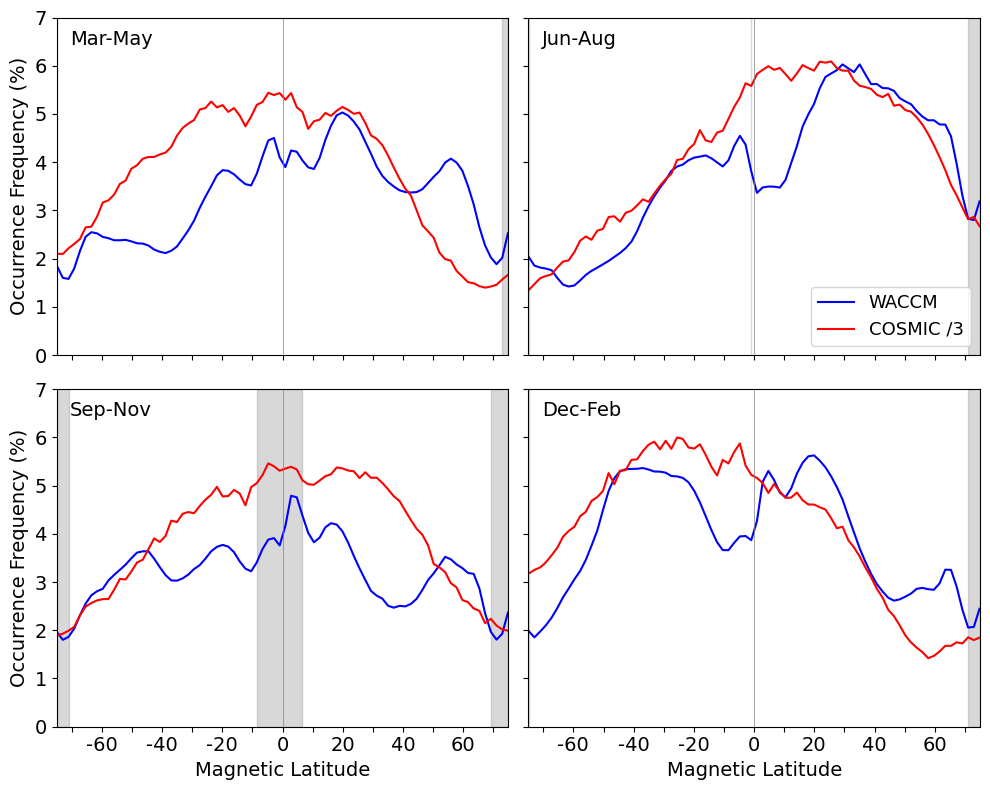

In [7]:
########### Magnetic L A T line plot (WACCM vs COSMIC) ##########

lat_values = np.arange(-90, 95, 5)
lat_bin_edges = lat_values
lat_bin_midpoints = (lat_bin_edges[:-1] + lat_bin_edges[1:]) / 2

factor = 3

# Create a 2x2 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), sharex=True)

# Plot WACCM data
axes[0, 0].plot(mlat, spr_Occ_Fr_maglat, color='blue', label='WACCM')
axes[0, 1].plot(mlat, sum_Occ_Fr_maglat, color='blue', label='WACCM')
axes[1, 0].plot(mlat, aut_Occ_Fr_maglat, color='blue', label='WACCM')
axes[1, 1].plot(mlat, win_Occ_Fr_maglat, color='blue', label='WACCM')

# Plot COSMIC data magnetic lat lon
axes[0, 0].plot(mlat_c, spr_Occ_Fr_maglat_c / factor, color='red', label=f'COSMIC /{factor}')
axes[0, 1].plot(mlat_c, sum_Occ_Fr_maglat_c / factor, color='red', label=f'COSMIC /{factor}')
axes[1, 0].plot(mlat_c, aut_Occ_Fr_maglat_c / factor, color='red', label=f'COSMIC /{factor}')
axes[1, 1].plot(mlat_c, win_Occ_Fr_maglat_c / factor, color='red', label=f'COSMIC /{factor}')

# Old snippet from another plot - not worked out std devs for Davids data yet
# # # Fill between upper and lower bounds of the error
# axes[0, 0].fill_between(lat_bin_midpoints, (spr_ocfr_LT_m_lat.values - stdev_ocfr_mlat_LT_spr_lat.values) / factor, (spr_ocfr_LT_m_lat.values + stdev_ocfr_mlat_LT_spr_lat.values) / factor, color='red', alpha=0.3)
# axes[0, 1].fill_between(lat_bin_midpoints, (sum_ocfr_LT_m_lat.values - stdev_ocfr_mlat_LT_sum_lat.values) / factor, (sum_ocfr_LT_m_lat.values + stdev_ocfr_mlat_LT_sum_lat.values) / factor, color='red', alpha=0.3)
# axes[1, 0].fill_between(lat_bin_midpoints, (aut_ocfr_LT_m_lat.values - stdev_ocfr_mlat_LT_aut_lat.values) / factor, (aut_ocfr_LT_m_lat.values + stdev_ocfr_mlat_LT_aut_lat.values) / factor, color='red', alpha=0.3)
# axes[1, 1].fill_between(lat_bin_midpoints, (win_ocfr_LT_m_lat.values - stdev_ocfr_mlat_LT_win_lat.values) / factor, (win_ocfr_LT_m_lat.values + stdev_ocfr_mlat_LT_win_lat.values) / factor, color='red', alpha=0.3)

ylim_min = 0
ylim_max = 7

nmeas_lim = 50 #5

#=============================================================================================
# Iterate through each subplot to add grey rectangles where nmeas_lonavg is less than limit set
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        
        nmeas_lonavg = None
        
        #----------
        if i == 0 and j == 0:
            nmeas_lonavg = spr_nmeas_maglat_c
        elif i == 0 and j == 1:
            nmeas_lonavg = sum_nmeas_maglat_c
        elif i == 1 and j == 0:
            nmeas_lonavg = aut_nmeas_maglat_c
        elif i == 1 and j == 1:
            nmeas_lonavg = win_nmeas_maglat_c
            
        mask = nmeas_lonavg < nmeas_lim
        
        lat_masked = mlat_c[mask]
        
        # Find the indices where the condition is True
        indices = np.where(mask)[0]
        
        # Initialize variables to track the start and end points of each region
        start = None
        end = None
        
        # Iterate through the indices and identify consecutive regions where the condition is met
        for idx in indices:
            if start is None:
                start = idx
                end = idx
            elif idx == end + 1:
                end = idx
            else:
                # Fill the region between the start and end points
                min_lat_masked = np.min(mlat_c[start:end+1])
                max_lat_masked = np.max(mlat_c[start:end+1])
                ax.fill_betweenx([ylim_min, ylim_max], min_lat_masked, max_lat_masked, color='gray', alpha=0.3)
                start = idx
                end = idx
        
        # If there is a remaining region after iterating through all indices, fill it
        if start is not None and end is not None:
            min_lat_masked = np.min(mlat_c[start:end+1])
            max_lat_masked = np.max(mlat_c[start:end+1])
            ax.fill_betweenx([ylim_min, ylim_max], min_lat_masked, max_lat_masked, color='gray', alpha=0.3)
#=============================================================================================

# Set common labels and legend
for ax in axes.flatten():
    ax.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
    ax.set_xlim(-75, 75)
    
    xticks = np.arange(-70, 71, 10)  # Ticks every 10 units from -70 to 70
    xticklabels = ['' if tick % 20 != 0 else str(tick) for tick in xticks]  # Label every 20th tick
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    
    #ax.legend()
    ax.set_ylim(ylim_min, ylim_max)

for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        label = ['Mar-May', 'Jun-Aug', 'Sep-Nov','Dec-Feb'][i * 2 + j]
        ax.text(0.03, 0.92, label, transform=ax.transAxes, fontsize=14)
        ax.tick_params(axis='both', labelsize=14)
        if i == 1:
            ax.set_xlabel('Magnetic Latitude', fontsize=14)
            #ax.set_yticks(np.arange(0, 11, 2))
        if j == 0:
            ax.set_ylabel('Occurrence Frequency (%)', fontsize=14)
        else:
            ax.set_yticklabels([])  # Set yticklabels to an empty list for other columns

        
axes[0, 1].legend(loc='lower right', fontsize=13)  # Move the legend
        
plt.tight_layout() # Adjust layout

# Save and show the figure
figname = f'{run_name}_Combined_MagLat_f-{factor}.png'
plt.savefig('Figures/Daviddata/' + str(figname), dpi=400, bbox_inches='tight')

plt.show()

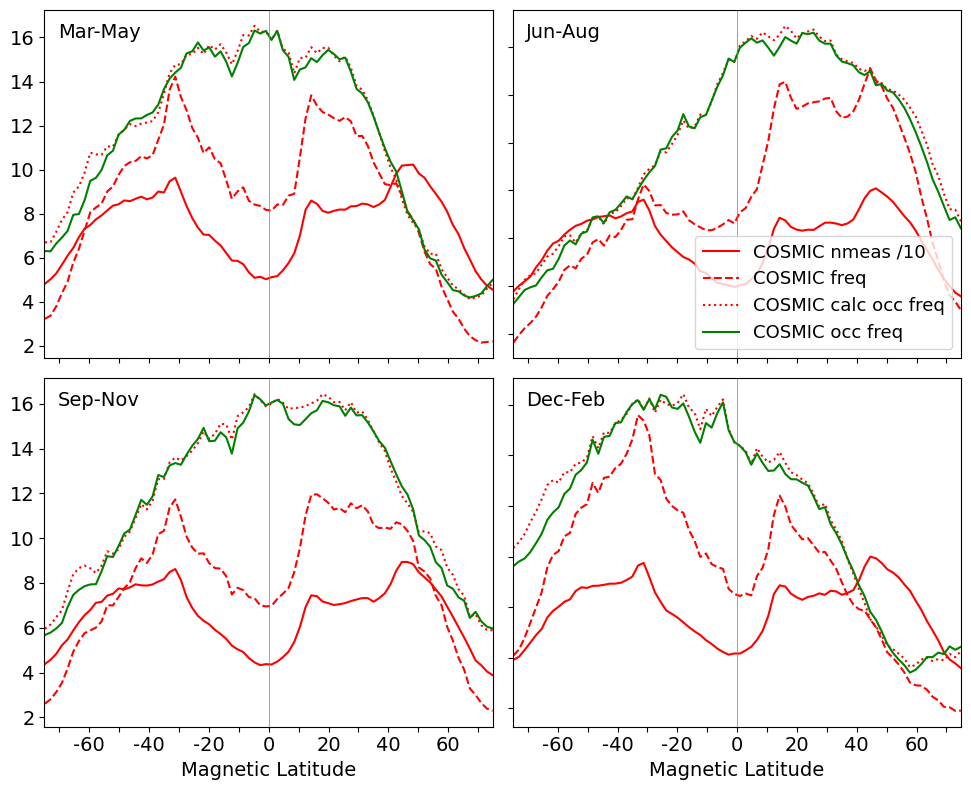

In [8]:
########### Magnetic L A T line plot (WACCM vs COSMIC) ##########
###########              nmeas and freq


lat_values = np.arange(-90, 95, 5)
lat_bin_edges = lat_values
lat_bin_midpoints = (lat_bin_edges[:-1] + lat_bin_edges[1:]) / 2

factor = 3

# Create a 2x2 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), sharex=True)

# # Plot WACCM data
# axes[0, 0].plot(mlat, spr_Occ_Fr_maglat, color='blue', label='WACCM')
# axes[0, 1].plot(mlat, sum_Occ_Fr_maglat, color='blue', label='WACCM')
# axes[1, 0].plot(mlat, aut_Occ_Fr_maglat, color='blue', label='WACCM')
# axes[1, 1].plot(mlat, win_Occ_Fr_maglat, color='blue', label='WACCM')

# Plot COSMIC data magnetic lat lon
axes[0, 0].plot(mlat_c, spr_nmeas_maglat_c /10, color='red', label=f'COSMIC nmeas /10')
axes[0, 1].plot(mlat_c, sum_nmeas_maglat_c /10, color='red', label=f'COSMIC nmeas /10')
axes[1, 0].plot(mlat_c, aut_nmeas_maglat_c /10, color='red', label=f'COSMIC nmeas /10')
axes[1, 1].plot(mlat_c, win_nmeas_maglat_c /10, color='red', label=f'COSMIC nmeas /10')

axes[0, 0].plot(mlat_c, spr_freq_maglat_c , color='red', linestyle = 'dashed', label=f'COSMIC freq')
axes[0, 1].plot(mlat_c, sum_freq_maglat_c , color='red', linestyle = 'dashed', label=f'COSMIC freq')
axes[1, 0].plot(mlat_c, aut_freq_maglat_c , color='red', linestyle = 'dashed', label=f'COSMIC freq')
axes[1, 1].plot(mlat_c, win_freq_maglat_c , color='red', linestyle = 'dashed', label=f'COSMIC freq')

axes[0, 0].plot(mlat_c, (spr_freq_maglat_c/spr_nmeas_maglat_c)*100 , color='red', linestyle = 'dotted', label=f'COSMIC calc occ freq')
axes[0, 1].plot(mlat_c, (sum_freq_maglat_c/sum_nmeas_maglat_c)*100 , color='red', linestyle = 'dotted', label=f'COSMIC calc occ freq')
axes[1, 0].plot(mlat_c, (aut_freq_maglat_c/aut_nmeas_maglat_c)*100 , color='red', linestyle = 'dotted', label=f'COSMIC calc occ freq')
axes[1, 1].plot(mlat_c, (win_freq_maglat_c/win_nmeas_maglat_c)*100 , color='red', linestyle = 'dotted', label=f'COSMIC calc occ freq')

axes[0, 0].plot(mlat_c, spr_Occ_Fr_maglat_c, color='green', label=f'COSMIC occ freq')
axes[0, 1].plot(mlat_c, sum_Occ_Fr_maglat_c, color='green', label=f'COSMIC occ freq')
axes[1, 0].plot(mlat_c, aut_Occ_Fr_maglat_c, color='green', label=f'COSMIC occ freq')
axes[1, 1].plot(mlat_c, win_Occ_Fr_maglat_c, color='green', label=f'COSMIC occ freq')

ylim_min = 0
ylim_max = 7

nmeas_lim = 50 #5

# Set common labels and legend
for ax in axes.flatten():
    ax.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
    ax.set_xlim(-75, 75)
    
    xticks = np.arange(-70, 71, 10)  # Ticks every 10 units from -70 to 70
    xticklabels = ['' if tick % 20 != 0 else str(tick) for tick in xticks]  # Label every 20th tick
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    
    #ax.legend()
    #ax.set_ylim(ylim_min, ylim_max)

for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        label = ['Mar-May', 'Jun-Aug', 'Sep-Nov','Dec-Feb'][i * 2 + j]
        ax.text(0.03, 0.92, label, transform=ax.transAxes, fontsize=14)
        ax.tick_params(axis='both', labelsize=14)
        if i == 1:
            ax.set_xlabel('Magnetic Latitude', fontsize=14)
            #ax.set_yticks(np.arange(0, 11, 2))
        if j == 0:
            ax.set_ylabel('', fontsize=14)
        else:
            ax.set_yticklabels([])  # Set yticklabels to an empty list for other columns

        
axes[0, 1].legend(loc='lower right', fontsize=13)  # Move the legend
        
plt.tight_layout() # Adjust layout

# Save and show the figure
#figname = f'{run_name}_Combined_MagLat_.png'
#plt.savefig('Figures/Daviddata/' + str(figname), dpi=400, bbox_inches='tight')

plt.show()